# <center>Telecom Churn : Prediction</center> 

## Problem Statement<br>
Analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.<br>
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. The telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
## Goal
- Analyse customer data with **Prepaid** pland in **India and Southest Asia**
- Identify High-Value customer based on there uses
    - Take first 2 month average recharge amount
    - Identify customer with more than **70<sup>th</sup> Percentile** average recharge amount 
- Here we have 4 month data (Jun, July, August, September)
    - Tag churner in the last month (September) using fourth month data
    - Based on usage of fourth month such as incoming and outgoing call and internet use
    - After prediction remove all the attributes corresponding to the churn phase


## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import warnings
%matplotlib inline

In [2]:
from IPython.display import display, Markdown
def customprint(text):
    display(Markdown(text))

In [3]:
pd.set_option('display.max.columns', 250)
warnings.filterwarnings('ignore')

## Load Data

In [4]:
custDf = pd.read_csv("telecom_churn_data.csv")

In [5]:
custDf.shape

(99999, 226)

In [6]:
custDf.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

## Data Cleaning and Manipulation

In [7]:
#changing few column names
custDf.rename(columns={'jun_vbc_3g':'vbc_3g_6', 'jul_vbc_3g':'vbc_3g_7', 'aug_vbc_3g':'vbc_3g_8', 'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

### EDA (Exploratory Data Analysis)

In [8]:
custDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to vbc_3g_9
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [9]:
#Checking Data Types for Each of the Columns
custDf.dtypes

mobile_number             int64
circle_id                 int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
last_date_of_month_7     object
last_date_of_month_8     object
last_date_of_month_9     object
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
arpu_9                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
onnet_mou_9             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
offnet_mou_9            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_ic_mou_9           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
roam_og_mou_9           float64
loc_og_t2t_mou_6        float64
                         ...   
arpu_2g_

#### Summary Statics for customer

In [10]:
#Summary Statics for all numeric variables
custDf.describe(include = [np.number])

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,

In [11]:
#Summary Statics for all non-numeric variables
custDf.describe(exclude= [np.number])

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
count,99999,99398,98899,98340,98392,98232,96377,95239,25153,25571,26339,25922
unique,1,1,1,1,30,31,31,30,30,31,31,30
top,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/30/2014,7/31/2014,8/31/2014,9/29/2014,6/30/2014,7/31/2014,8/31/2014,9/29/2014
freq,99999,99398,98899,98340,16960,17288,14706,22623,1888,1813,1998,2329


### Checking for Missing Values

In [12]:
custDf.isna().sum().sort_values(ascending = False)

count_rech_2g_6             74846
date_of_last_rech_data_6    74846
count_rech_3g_6             74846
av_rech_amt_data_6          74846
max_rech_data_6             74846
total_rech_data_6           74846
arpu_3g_6                   74846
arpu_2g_6                   74846
night_pck_user_6            74846
fb_user_6                   74846
arpu_3g_7                   74428
count_rech_2g_7             74428
fb_user_7                   74428
count_rech_3g_7             74428
arpu_2g_7                   74428
av_rech_amt_data_7          74428
max_rech_data_7             74428
night_pck_user_7            74428
total_rech_data_7           74428
date_of_last_rech_data_7    74428
night_pck_user_9            74077
date_of_last_rech_data_9    74077
fb_user_9                   74077
arpu_2g_9                   74077
max_rech_data_9             74077
arpu_3g_9                   74077
total_rech_data_9           74077
av_rech_amt_data_9          74077
count_rech_3g_9             74077
count_rech_2g_

In [13]:
missingDf = pd.DataFrame(data=custDf.isnull().sum() / custDf.index.size * 100, columns=['MissingPercent'])
missingDf =  missingDf[missingDf['MissingPercent'] > 0]
missingDf.reset_index(inplace=True)
missingDf.columns = ['Feature', 'MissingPercent']
missingDf[['Month', 'Feature']] = missingDf['Feature'].apply(lambda x : pd.Series([6, x.replace('_6', '')] if x.endswith('_6') else ([7, x.replace('_7', '')] if x.endswith('_7') else ([8, x.replace('_8', '')] if x.endswith('_8') else ([9, x.replace('_9', '')] if x.endswith('_9') else [None, x])))))

In [14]:
#Categorizing the missing value % by month and feature
pvtDf =  missingDf[~np.isnan(missingDf['MissingPercent'])].pivot_table(index=['Feature'], columns=['Month'])
pvtDf['MissingPercent'].sort_values(by=[6.0], ascending=False)

Month,6.0,7.0,8.0,9.0
Feature,,,,
arpu_2g,74.846748,74.428744,73.660737,74.077741
date_of_last_rech_data,74.846748,74.428744,73.660737,74.077741
night_pck_user,74.846748,74.428744,73.660737,74.077741
arpu_3g,74.846748,74.428744,73.660737,74.077741
fb_user,74.846748,74.428744,73.660737,74.077741
max_rech_data,74.846748,74.428744,73.660737,74.077741
total_rech_data,74.846748,74.428744,73.660737,74.077741
count_rech_2g,74.846748,74.428744,73.660737,74.077741
av_rech_amt_data,74.846748,74.428744,73.660737,74.077741


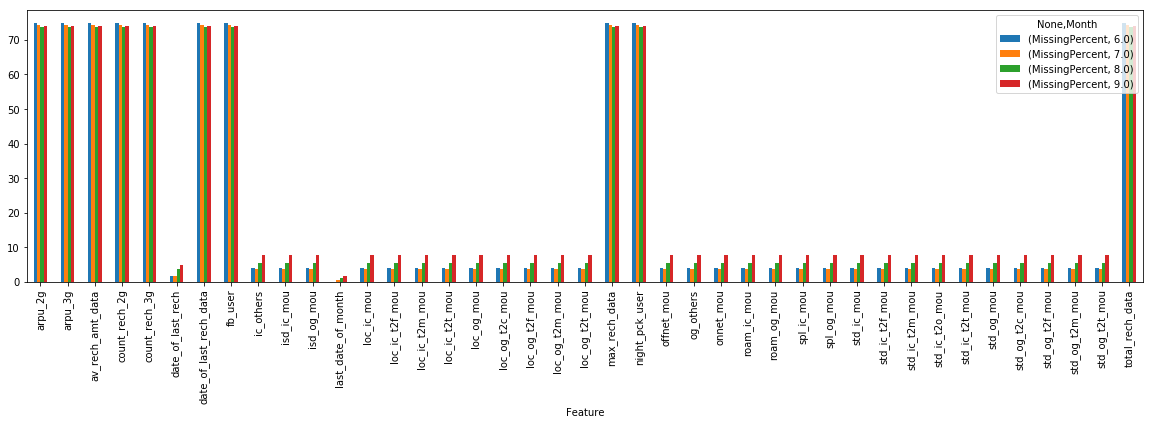

In [15]:
#Comparing the missing value with respect to month and feature
pvtDf.plot(kind= 'bar', figsize=(20, 5), legend='bottom')
plt.show()

**As observed from the above graph the missing value % for all the months are following similar trends. This implies that customer have not opted to for the service.**

In [16]:
custDf.filter(regex='rech', axis = 1).describe()

,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000
mean,7.558806,7.700367,7.212912,6.893019,327.514615,322.962970,324.157122,303.345673,104.637486,104.752398,107.728207,101.943889,2.463802,2.666419,2.651999,2.441170,126.393392,126.729459,125.717301,124.94144,1.864668,2.044699,2.016288,1.781807,0.599133,0.621720,0.635711,0.659363,192.600982,200.981292,197.526489,192.734315
std,7.078405,7.070422,7.203753,7.096261,398.019701,408.114237,416.540455,404.588583,120.614894,124.523970,126.902505,125.375109,2.789128,3.031593,3.074987,2.516339,108.477235,109.765267,109.437851,111.36376,2.570254,2.768332,2.720132,2.214701,1.274428,1.394524,1.422827,1.411513,192.646318,196.791224,191.301305,188.400286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.500000,1.000000
25%,3.000000,3.000000,3.000000,3.000000,109.000000,100.000000,90.000000,52.000000,30.000000,30.000000,30.000000,28.000000,1.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,25.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,82.000000,92.000000,87.000000,69.000000
50%,6.000000,6.000000,5.000000,5.000000,230.000000,220.000000,225.000000,200.000000,110.000000,110.000000,98.000000,61.000000,1.000000,1.000000,1.000000,2.000000,145.000000,145.000000,145.000000,145.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,154.000000,154.000000,154.000000,164.000000
75%,9.000000,10.000000,9.000000,9.000000,437.500000,428.000000,434.500000,415.000000,120.000000,128.000000,144.000000,144.000000,3.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,179.00000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,252.000000,252.000000,252.000000,252.000000
max,307.000000,138.000000,196.000000,131.000000,35190.000000,40335.000000,45320.000000,37235.000000,4010.000000,4010.000000,4449.000000,3399.000000,61.000000,54.000000,60.000000,84.000000,1555.000000,1555.000000,1555.000000,1555.00000,42.000000,48.000000,44.000000,40.000000,29.000000,35.000000,45.000000,49.000000,7546.000000,4365.000000,4076.000000,4061.000000


In [17]:
custDf.filter(regex='date', axis = 1).describe()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
count,99999,99398,98899,98340,98392,98232,96377,95239,25153,25571,26339,25922
unique,1,1,1,1,30,31,31,30,30,31,31,30
top,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/30/2014,7/31/2014,8/31/2014,9/29/2014,6/30/2014,7/31/2014,8/31/2014,9/29/2014
freq,99999,99398,98899,98340,16960,17288,14706,22623,1888,1813,1998,2329


### Indentify High-Value customer

In [18]:
#Check for different recharge amount and recharge count
custDf[[c for c in custDf.columns if ((c.endswith('_6')) 
                                      & (('rch' in c) | 
                                         ('rech' in c) | 
                                         ('sachet' in c) | 
                                         ('monthly' in c) | 
                                         ('night' in c) | 
                                         ('VBC' in c)))]].tail(5)

,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,date_of_last_rech_6,last_day_rch_amt_6,date_of_last_rech_data_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6,night_pck_user_6,monthly_2g_6,sachet_2g_6,monthly_3g_6,sachet_3g_6
99994,2,60,60,6/3/2014,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
99995,5,110,110,6/17/2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
99996,5,119,50,6/13/2014,30,6/13/2014,2.0,25.0,2.0,0.0,39.0,0.0,0,2,0,0
99997,3,381,202,6/17/2014,202,6/17/2014,3.0,202.0,1.0,2.0,583.0,0.0,0,1,1,1
99998,5,710,175,6/16/2014,175,6/11/2014,1.0,154.0,1.0,0.0,154.0,0.0,1,0,0,0


In [19]:
custDf[['total_rech_num_6','total_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'sachet_2g_6', 'sachet_3g_6','monthly_2g_6','sachet_2g_6','monthly_3g_6']][~np.isnan(custDf['total_rech_data_6'])].head()

,total_rech_num_6,total_rech_data_6,count_rech_2g_6,count_rech_3g_6,sachet_2g_6,sachet_3g_6,monthly_2g_6,sachet_2g_6,monthly_3g_6
0,4,1.0,0.0,1.0,0,0,0,0,1
4,5,1.0,1.0,0.0,1,0,0,1,0
19,2,1.0,1.0,0.0,0,0,1,0,0
32,6,3.0,3.0,0.0,3,0,0,3,0
33,7,5.0,0.0,5.0,0,1,0,0,4


In [20]:
custDf[['total_rech_amt_6','max_rech_amt_6', 'max_rech_data_6', 'av_rech_amt_data_6']][~np.isnan(custDf['total_rech_data_6'])].head()

,total_rech_amt_6,max_rech_amt_6,max_rech_data_6,av_rech_amt_data_6
0,362,252,252.0,252.0
4,196,56,56.0,56.0
19,154,154,154.0,154.0
32,69,25,25.0,64.0
33,1058,252,252.0,1057.0


In [21]:
print("Missing value : Average Recharge Amount for data (June) : ", custDf[np.isnan(custDf['av_rech_amt_data_6']) & custDf['total_rech_data_6'] > 0].size)
print("Missing value : Average Recharge Amount for data (July) : ", custDf[np.isnan(custDf['av_rech_amt_data_7']) & custDf['total_rech_data_7'] > 0].size)
print("Missing value : Average Recharge Amount for data (August) : ", custDf[np.isnan(custDf['av_rech_amt_data_8']) & custDf['total_rech_data_8'] > 0].size)

Missing value : Average Recharge Amount for data (June) :  0
Missing value : Average Recharge Amount for data (July) :  0
Missing value : Average Recharge Amount for data (August) :  0


In [22]:
#Calculate Total recharge amount spend on data for specific month
custDf['total_rech_amt_data_6'] = custDf['av_rech_amt_data_6'] * custDf['total_rech_data_6']
custDf['total_rech_amt_data_7'] = custDf['av_rech_amt_data_7'] * custDf['total_rech_data_7']
custDf['total_rech_amt_data_8'] = custDf['av_rech_amt_data_8'] * custDf['total_rech_data_8']

In [23]:
custDf['total_rech_6'] = custDf[['total_rech_amt_data_6', 'total_rech_amt_6']].sum(axis=1)
custDf['total_rech_7'] = custDf[['total_rech_amt_data_7', 'total_rech_amt_7']].sum(axis=1)
custDf['total_rech_8'] = custDf[['total_rech_amt_data_8', 'total_rech_amt_8']].sum(axis=1)
custDf['av_rech_6_7'] = custDf[['total_rech_6','total_rech_7']].mean(axis=1)

In [24]:
#70th percentile of two month average recharge  
rechAmt = custDf['av_rech_6_7'].quantile(0.7)
rechAmt

478.0

In [25]:
#High value customer with average recharge amount greater than 70 percentile
hvCust = custDf[custDf['av_rech_6_7'] >= rechAmt]

In [26]:
hvCust.shape

(30001, 233)

In [27]:
#Will drop 'av_rech_6_7' columns which might create confusion in EDA process
hvCust.drop(labels=['av_rech_6_7'], axis=1, inplace=True)

Tag churner based on Incoming & Outgoing call as well as Internet usages in September month.

In [28]:
hvCust['churn'] = hvCust.apply(lambda x : 1 if ((x['total_ic_mou_9'] == 0) & (x['total_og_mou_9'] == 0) & (x['vol_2g_mb_9'] == 0) & (x['vol_3g_mb_9'] == 0)) else 0, axis=1)

In [29]:
hvCust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9', 'churn']].head(10)

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9,churn
0,0.00,0.00,0.00,0.00,1
7,0.00,0.00,0.00,0.00,1
8,34.91,142.18,0.00,0.00,0
21,252.61,1031.53,0.00,0.00,0
23,127.48,127.63,13.93,314.74,0
33,114.16,1.70,30.92,5588.11,0
38,114.09,708.04,0.00,0.00,0
41,165.84,89.13,0.00,0.00,0
48,894.81,2319.01,0.00,0.00,0
53,680.61,503.06,0.82,0.00,0


In [30]:
#Drop attribute from churn phase
colsToDel = [c for c in hvCust.columns if "_9" in c]
hvCust.drop(labels=colsToDel, inplace=True, axis=1)
hvCust.shape

(30001, 178)

In [31]:
# as name suggested "Last Date of Month" column contain unique value (Last day of that month)
#So we can drop these 3 columns

hvCust.drop(labels=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], inplace=True, axis=1)

In [32]:
hvCust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 175 entries, mobile_number to churn
dtypes: float64(141), int64(28), object(6)
memory usage: 40.3+ MB


In [33]:
#Fetch day from last recharge date of specific month
hvCust['date_of_last_rech_6'] = pd.DatetimeIndex(hvCust['date_of_last_rech_6']).day
hvCust['date_of_last_rech_7'] = pd.DatetimeIndex(hvCust['date_of_last_rech_7']).day
hvCust['date_of_last_rech_8'] = pd.DatetimeIndex(hvCust['date_of_last_rech_8']).day
hvCust['date_of_last_rech_data_6'] = pd.DatetimeIndex(hvCust['date_of_last_rech_data_6']).day
hvCust['date_of_last_rech_data_7'] = pd.DatetimeIndex(hvCust['date_of_last_rech_data_7']).day
hvCust['date_of_last_rech_data_8'] = pd.DatetimeIndex(hvCust['date_of_last_rech_data_8']).day

In [34]:
hvCust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 175 entries, mobile_number to churn
dtypes: float64(147), int64(28)
memory usage: 40.3 MB


In [35]:
#hvCust[hvCust['total_rech_amt_6'] == 0][[c for c in hvCust.columns if '_6' in c]]
hvCust[np.isnan(hvCust['total_rech_data_6']) | 
      np.isnan(hvCust['total_rech_amt_data_6']) |
      np.isnan(hvCust['night_pck_user_6']) |
      np.isnan(hvCust['max_rech_data_6']) |
      np.isnan(hvCust['fb_user_6']) |
      np.isnan(hvCust['count_rech_3g_6']) |
      np.isnan(hvCust['count_rech_2g_6']) |
      np.isnan(hvCust['av_rech_amt_data_6']) |
      np.isnan(hvCust['arpu_3g_6']) |
      np.isnan(hvCust['arpu_2g_6'])][[c for c in hvCust.columns if '_6' in c]].head(10)

,arpu_6,onnet_mou_6,offnet_mou_6,roam_ic_mou_6,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_t2c_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,og_others_6,total_og_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_t2o_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6,ic_others_6,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,date_of_last_rech_6,last_day_rch_amt_6,date_of_last_rech_data_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6,vol_2g_mb_6,vol_3g_mb_6,arpu_3g_6,arpu_2g_6,night_pck_user_6,monthly_2g_6,sachet_2g_6,monthly_3g_6,sachet_3g_6,fb_user_6,vbc_3g_6,total_rech_amt_data_6,total_rech_6
7,1069.180,57.84,453.43,16.23,23.74,51.39,308.63,62.13,0.00,422.16,4.30,49.89,6.66,0.0,60.86,0.00,4.50,0.00,487.53,58.14,217.56,152.16,427.88,36.89,91.44,52.19,0.0,180.54,626.46,0.21,2.06,15.74,5,1580,1580,27.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,18.74,NaN,1580.0
8,378.721,413.69,94.66,0.00,0.00,297.13,80.96,0.00,0.00,378.09,116.56,13.69,0.00,0.0,130.26,0.00,0.00,0.00,508.36,23.84,57.58,0.00,81.43,0.00,22.43,0.00,0.0,22.43,103.86,0.00,0.00,0.00,19,437,90,25.0,50,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,122.16,NaN,437.0
21,514.453,102.41,757.93,0.00,0.00,4.48,91.81,0.75,0.00,97.04,97.93,665.36,0.00,0.0,763.29,0.00,0.00,0.00,860.34,2.48,118.23,4.61,125.33,14.06,67.69,0.00,0.0,81.76,207.09,0.00,0.00,0.00,22,600,50,30.0,30,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,600.0
23,74.350,48.96,85.41,0.00,0.00,48.96,82.94,0.00,0.00,131.91,0.00,2.36,0.00,0.0,2.36,0.00,0.10,0.00,134.38,20.71,95.91,0.00,116.63,0.51,2.43,0.00,0.0,2.94,119.58,0.00,0.00,0.00,3,0,0,18.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,0.0
38,363.987,248.99,88.86,0.00,0.00,29.88,33.76,0.00,0.00,63.64,219.11,55.09,0.00,0.0,274.21,0.00,0.00,0.00,337.86,8.68,37.99,0.00,46.68,4.54,19.56,0.00,0.0,24.11,70.79,0.00,0.00,0.00,27,420,30,30.0,20,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,420.0
41,482.832,86.39,232.36,0.00,0.00,86.39,142.69,54.14,0.00,283.24,0.00,0.00,34.68,0.0,34.68,0.79,0.03,0.00,318.76,59.54,12.18,11.70,83.43,0.00,0.00,0.00,0.0,0.00,278.31,0.00,194.31,0.56,4,496,150,24.0,150,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,496.0
48,1873.271,2061.69,1087.76,0.00,0.00,611.18,1012.04,19.34,0.06,1642.58,1450.51,56.29,0.00,0.0,1506.81,0.00,1.58,1.45,3152.43,361.94,842.49,7.94,1212.39,19.24,18.91,0.00,0.0,38.16,1250.56,0.00,0.00,0.00,13,2317,250,29.0,250,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,2317.0
69,809.518,181.63,1608.76,0.00,0.00,12.48,35.76,0.00,0.00,48.24,169.14,1572.99,0.00,0.0,1742.14,0.00,0.00,0.00,1790.39,212.03,40.88,2.76,255.68,0.00,0.18,0.00,0.0,0.18,255.86,0.00,0.00,0.00,16,986,110,30.0,110,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,986.0
73,2401.829,2020.84,3897.06,0.00,0.00,78.76,255.29,0.10,0.00,334.16,1942.08,3640.44,0.00,0.0,5582.53,0.00,1.21,11.90,5929.81,53.81,171.01,2.00,226.83,9.04,26.69,0.00,0.0,35.74,262.58,0.00,0.00,0.00,33,2759,150,30.0,110,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,2759.0
77,30.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,4,0,0,17.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,0.0


Apart from **date_of_last_rech** column all other column have some common pattern.<BR>
All feature variable related to Internet Service have **44% missing data in Jun, 43% in July and 47% in August ** month.<BR>
Same as internet service, calling service related features also have common trend.<BR>

This trend shows there are few customers only use calling service and not using any internet service, hence approx. 44% missing data for all columns of internet service related feature.<BR>
We can impute zero in such columns except last recharge date data column.

In [36]:
missingDf = pd.DataFrame(data=hvCust.isnull().sum() / hvCust.index.size * 100, columns=['MissingPercent'])
missingDf =  missingDf[missingDf['MissingPercent'] > 0]
missingDf.reset_index(inplace=True)
missingDf.columns = ['Feature', 'MissingPercent']
missingDf[['Month', 'Feature']] = missingDf['Feature'].apply(lambda x : pd.Series([6, x.replace('_6', '')] if x.endswith('_6') else ([7, x.replace('_7', '')] if x.endswith('_7') else ([8, x.replace('_8', '')] if x.endswith('_8') else [None, x]))))

In [37]:
pvtDf =  missingDf[~np.isnan(missingDf['MissingPercent'])].pivot_table(index=['Feature'], columns=['Month'])
pvtDf['MissingPercent'].sort_values(by=[6.0], ascending=False)

Month,6.0,7.0,8.0
Feature,,,
arpu_2g,44.148528,43.145228,46.825106
date_of_last_rech_data,44.148528,43.145228,46.825106
total_rech_amt_data,44.148528,43.145228,46.825106
night_pck_user,44.148528,43.145228,46.825106
arpu_3g,44.148528,43.145228,46.825106
fb_user,44.148528,43.145228,46.825106
max_rech_data,44.148528,43.145228,46.825106
total_rech_data,44.148528,43.145228,46.825106
av_rech_amt_data,44.148528,43.145228,46.825106


In [38]:
hvCust.drop(labels=['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'], axis=1, inplace=True)

In [39]:
cols = pvtDf[pvtDf['MissingPercent'][6] > 40].index
cols = [c + "_" + month for c in cols for month in ['6','7','8']]
cols.remove('date_of_last_rech_data_6')
cols.remove('date_of_last_rech_data_7')
cols.remove('date_of_last_rech_data_8')

In [40]:
hvCust[cols] = hvCust[cols].fillna(value=0)

In [41]:
#Drop rows of other missing data
hvCust.dropna(axis=0, inplace=True)

In [42]:
missingDf = pd.DataFrame(data=hvCust.isnull().sum() / hvCust.index.size * 100, columns=['MissingPercent'])
missingDf =  missingDf[missingDf['MissingPercent'] > 0]
missingDf.reset_index(inplace=True)
missingDf.columns = ['Feature', 'MissingPercent']

In [43]:
missingDf.sort_values(by='MissingPercent')

,Feature,MissingPercent


In [44]:
print(hvCust.shape)
print(hvCust['churn'].value_counts())

(28163, 172)
0    26625
1     1538
Name: churn, dtype: int64


As per definition **Good Phase** (i.e. June & July), customer is happy with service provider and in **Action Phase** (i.e. August) it shows show different behavior.<BR>
So will combine June & July data points for analysis and further use.

In [45]:
#Will exclude few variable such as categorical (0,1) and related to date/day
colToExclude = ['date_of_last_reach_6','date_of_last_reach_7','fb_user_6','fb_user_7','night_pck_user_6','night_pck_user_7']
for col in hvCust.columns:
    if (col.endswith('_6')) & (col not in colToExclude):
        hvCust[col + '_7'] = hvCust[[col, col.strip('_6') + '_7']].mean(axis=1)
        hvCust.drop(labels=[col, col.strip('_6') + '_7'], inplace=True, axis=1)

In [46]:
#Duplicate data check
hvCust[hvCust['mobile_number'].duplicated()]

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_t2c_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_t2o_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,date_of_last_rech_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,total_rech_amt_data_8,total_rech_8,churn,arpu_6_7,onnet_mou_6_7,offnet_mou_6_7,roam_ic_mou_6_7,roam_og_mou_6_7,loc_og_t2t_mou_6_7,loc_og_t2m_mou_6_7,loc_og_t2f_mou_6_7,loc_og_t2c_mou_6_7,loc_og_mou_6_7,std_og_t2t_mou_6_7,std_og_t2m_mou_6_7,std_og_t2f_mou_6_7,std_og_t2c_mou_6_7,std_og_mou_6_7,isd_og_mou_6_7,spl_og_mou_6_7,og_others_6_7,total_og_mou_6_7,loc_ic_t2t_mou_6_7,loc_ic_t2m_mou_6_7,loc_ic_t2f_mou_6_7,loc_ic_mou_6_7,std_ic_t2t_mou_6_7,std_ic_t2m_mou_6_7,std_ic_t2f_mou_6_7,std_ic_t2o_mou_6_7,std_ic_mou_6_7,total_ic_mou_6_7,spl_ic_mou_6_7,isd_ic_mou_6_7,ic_others_6_7,total_rech_num_6_7,total_rech_amt_6_7,max_rech_amt_6_7,date_of_last_rech_6_7,last_day_rch_amt_6_7,total_rech_data_6_7,max_rech_data_6_7,count_rech_2g_6_7,count_rech_3g_6_7,av_rech_amt_data_6_7,vol_2g_mb_6_7,vol_3g_mb_6_7,arpu_3g_6_7,arpu_2g_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,vbc_3g_6_7,total_rech_amt_data_6_7,total_rech_6_7


In [47]:
hvCust.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_t2c_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_t2o_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,date_of_last_rech_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,total_rech_amt_data_8,total_rech_8,churn,arpu_6_7,onnet_mou_6_7,offnet_mou_6_7,roam_ic_mou_6_7,roam_og_mou_6_7,loc_og_t2t_mou_6_7,loc_og_t2m_mou_6_7,loc_og_t2f_mou_6_7,loc_og_t2c_mou_6_7,loc_og_mou_6_7,std_og_t2t_mou_6_7,std_og_t2m_mou_6_7,std_og_t2f_mou_6_7,std_og_t2c_mou_6_7,std_og_mou_6_7,isd_og_mou_6_7,spl_og_mou_6_7,og_others_6_7,total_og_mou_6_7,loc_ic_t2t_mou_6_7,loc_ic_t2m_mou_6_7,loc_ic_t2f_mou_6_7,loc_ic_mou_6_7,std_ic_t2t_mou_6_7,std_ic_t2m_mou_6_7,std_ic_t2f_mou_6_7,std_ic_t2o_mou_6_7,std_ic_mou_6_7,total_ic_mou_6_7,spl_ic_mou_6_7,isd_ic_mou_6_7,ic_others_6_7,total_rech_num_6_7,total_rech_amt_6_7,max_rech_amt_6_7,date_of_last_rech_6_7,last_day_rch_amt_6_7,total_rech_data_6_7,max_rech_data_6_7,count_rech_2g_6_7,count_rech_3g_6_7,av_rech_amt_data_6_7,vol_2g_mb_6_7,vol_3g_mb_6_7,arpu_3g_6_7,arpu_2g_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,vbc_3g_6_7,total_rech_amt_data_6_7,total_rech_6_7
count,2.816300e+04,28163.0,28163.0,28163.0,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000
mean,7.001213e+09,109.0,0.0,0.0,0.0,528.992500,246.288657,351.089623,13.145865,20.926258,82.376724,159.312714,6.147877,1.789363,247.845569,155.918660,164.553111,1.646062,0.0,322.121339,1.989213,6.889342,0.061151,578.914527,66.142275,154.295671,15.191563,235.639315,14.625113,29.440255,2.692254,0.0,46.761176,295.165236,0.027889,11.437856,1.291328,10.435323,610.754607,164.597131,26.861343,94.779640,1.678727,72.496645,1.260981,0.417747,123.159975,109.831129,349.209687,62.057106,57.468928,0.013635,0.012889,0.011860,0.160210,1.100771,0.209459,0.208287,0.514576,0.526187,0.489472,1233.456627,173.745705,474.696750,1085.451357,0.054611,567.163074,271.207

Few feature variables contain only **0** value, we can drop such variables.<BR>
Also **circle_id** feature have common value **109**, we can drop this feature also.

In [48]:
s = hvCust.index.size
tempDf = pd.DataFrame([[c, hvCust[hvCust[c] == 0].index.size / s] for c in hvCust.columns if (hvCust[hvCust[c] == 0].index.size / s > 0.7)])
tempDf.columns = ['Feature', '% of 0']
tempDf.sort_values(by=['% of 0'], ascending = False)

,Feature,% of 0
0,loc_og_t2o_mou,1.000000
2,loc_ic_t2o_mou,1.000000
30,std_ic_t2o_mou_6_7,1.000000
27,std_og_t2c_mou_6_7,1.000000
1,std_og_t2o_mou,1.000000
7,std_og_t2c_mou_8,1.000000
11,std_ic_t2o_mou_8,1.000000
9,og_others_8,0.994070
18,night_pck_user_8,0.988140
17,night_pck_user_7,0.987111


In [49]:
#Will drop features having more than 98% zero values
colToDrop = list(tempDf[tempDf['% of 0'] > 0.98]['Feature'])
colToDrop.append('circle_id')
hvCust.drop(labels=colToDrop, inplace=True, axis=1)

## Visualising data

In [50]:
def PlotDestribution(data, feature1, featre2, message):
    customprint('**' + message + '**')
    plt.figure(figsize=(15,4))
    plt.subplot(1,4,1)
    sns.scatterplot(data=hvCust[hvCust['churn'] == 0], y='loc_og_mou_6_7', x='loc_og_mou_8' , alpha= 0.5 )
    sns.scatterplot(data=hvCust[hvCust['churn'] == 1], y='loc_og_mou_6_7', x='loc_og_mou_8' ,  alpha= 1 )
    plt.title('Good Vs Action Phase')

    plt.subplot(1,4,2)
    sns.distplot(hvCust[hvCust['churn']==1]['loc_og_mou_6_7'], bins = 30, kde = False)
    plt.title('Churn Dist')

    plt.subplot(1,4,3)
    sns.distplot(hvCust[hvCust['churn']==0]['loc_og_mou_6_7'], bins = 30, kde = False)
    plt.title('Non-Churn Dist')

    plt.subplot(1,4,4)
    sns.boxplot(x='churn', y='loc_og_mou_6_7', data=hvCust)
    sns.stripplot(x='churn', y='loc_og_mou_6_7', data=hvCust, jitter=True)
    plt.title('Non-Churn Dist')
    plt.show()

**ARPU (Average Revenue Per Customer)**

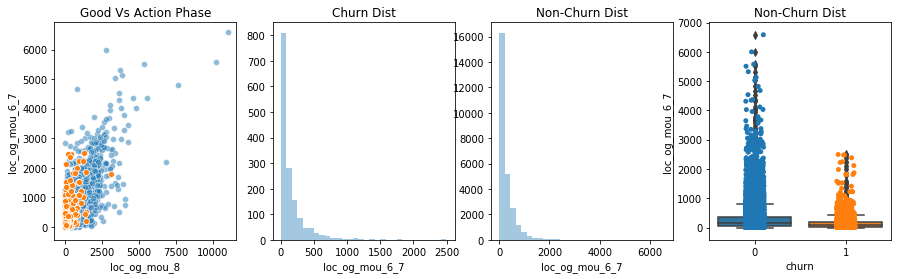

**Usage within the same network (onnet_mou)**

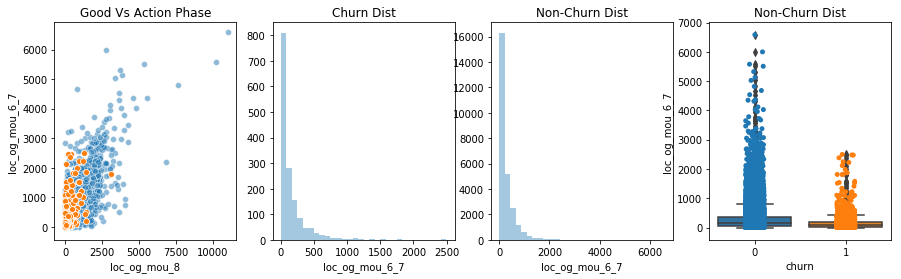

**Other Network Usage (Offnet_mou)**

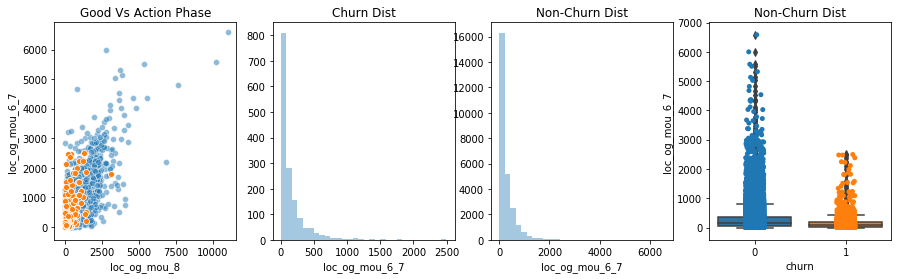

**Customer Away from the Home Network (Roaming) (roam_ic_mou)**

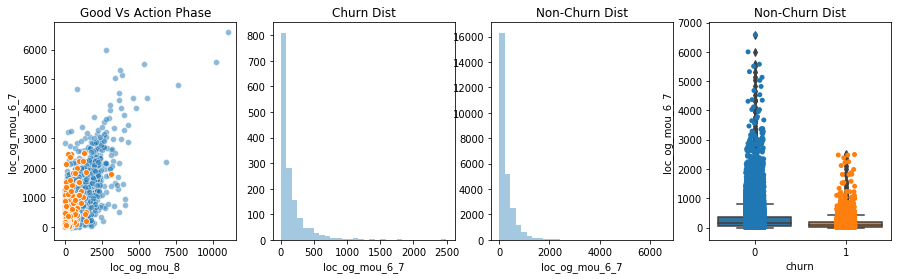

**Local Outgoing Calls within same operator (loc_og_mou)**

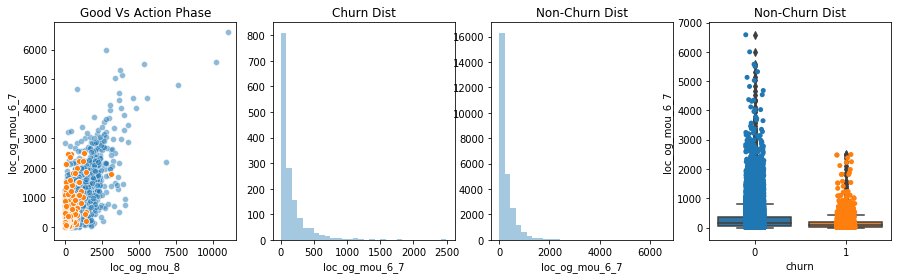

**Outside country calling across other zones (isd_og)**

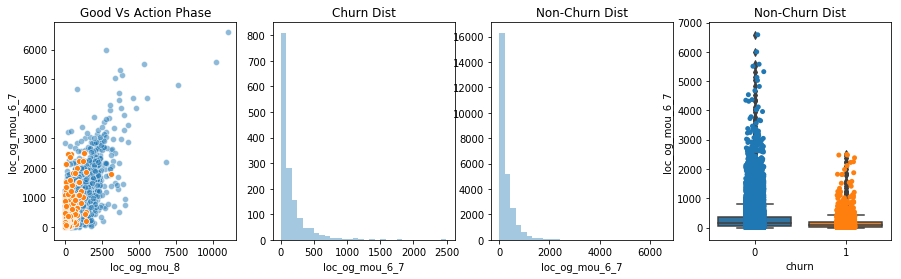

**Total Outgoing Calls (total_og_mou)**

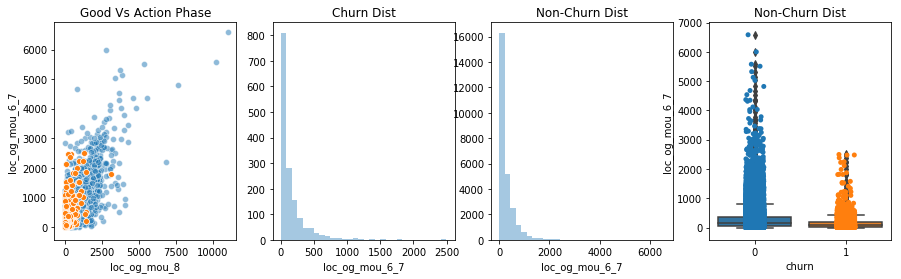

**Total Incoming Calls (total_ic_mou)**

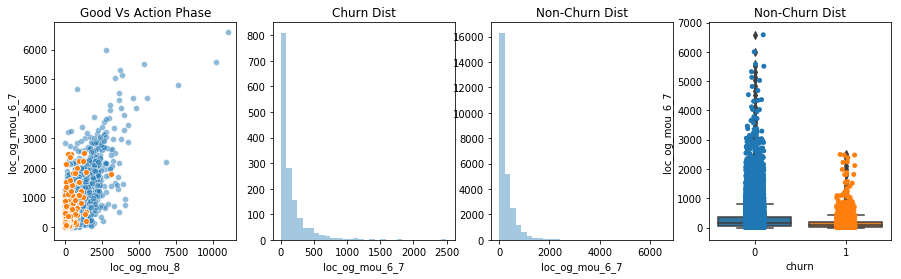

**Total Number of recharges done by the customer (total_rechnum)**

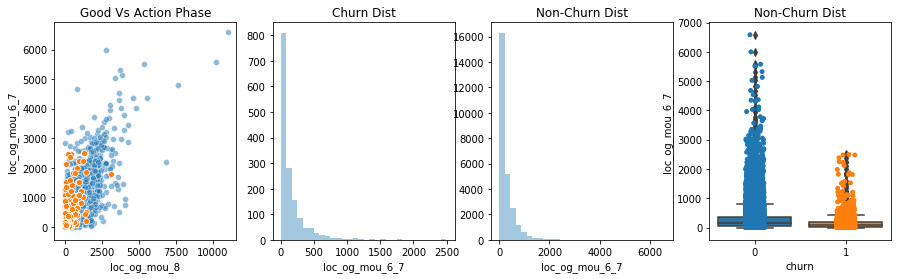

**Total amount of recharges done by the customer (total_rech)**

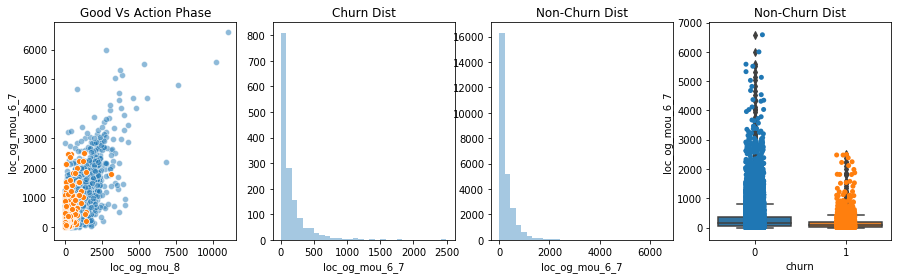

**Total amount of data recharges done by the customer (total_rech_amt_data)**

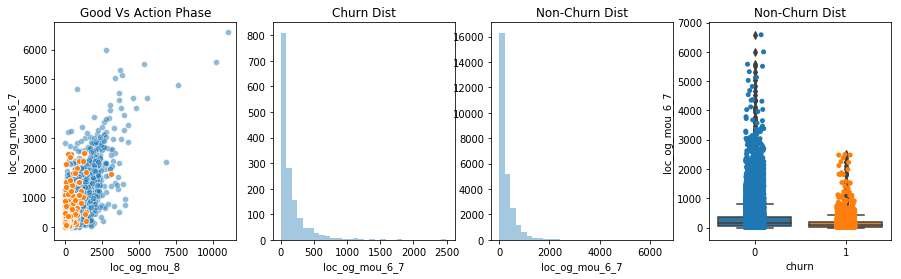

**2G data usage in MB (vol_2g_mb)**

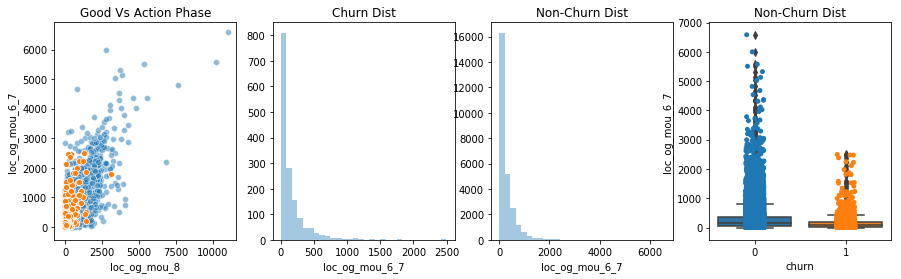

**3G data usage in MB (vol_3g_mb)**

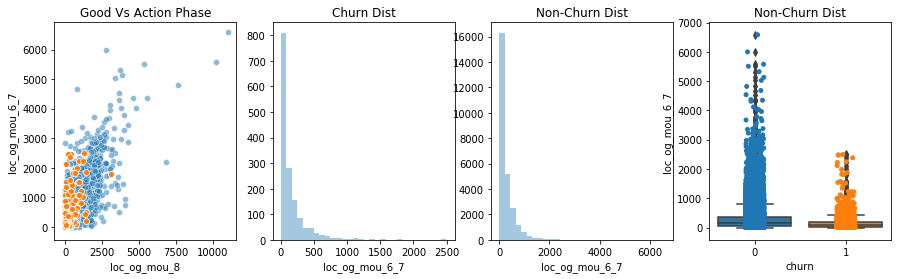

**Volume Base cost (vbc_3g)**

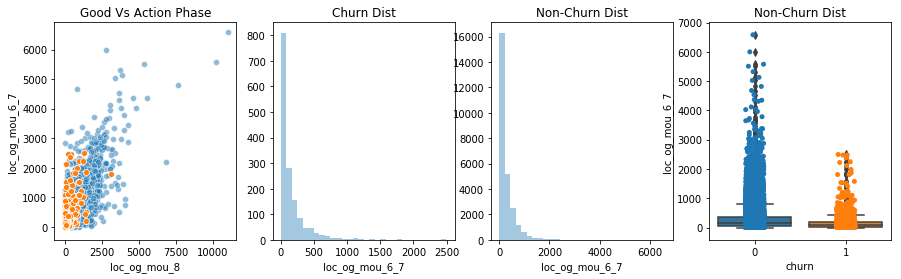

In [51]:
PlotDestribution(hvCust, 'arpu_6_7', 'arpu_8', 'ARPU (Average Revenue Per Customer)')
PlotDestribution(hvCust, 'onnet_mou_6_7','onnet_mou_8', 'Usage within the same network (onnet_mou)')
PlotDestribution(hvCust, 'offnet_mou_6_7','offnet_mou_8', 'Other Network Usage (Offnet_mou)')
PlotDestribution(hvCust, 'roam_ic_mou_6_7','roam_ic_mou_8', 'Customer Away from the Home Network (Roaming) (roam_ic_mou)')
PlotDestribution(hvCust, 'loc_og_mou_6_7','loc_og_mou_8', 'Local Outgoing Calls within same operator (loc_og_mou)')
PlotDestribution(hvCust, 'isd_og_mou_6_7','isd_og_mou_8', 'Outside country calling across other zones (isd_og)')
PlotDestribution(hvCust, 'total_og_mou_6_7','total_og_mou_8', 'Total Outgoing Calls (total_og_mou)')
PlotDestribution(hvCust, 'total_ic_mou_6_7','total_ic_mou_8', 'Total Incoming Calls (total_ic_mou)')
PlotDestribution(hvCust, 'total_rech_num_6_7','total_rech_num_8', 'Total Number of recharges done by the customer (total_rechnum)')
PlotDestribution(hvCust, 'total_rech_6_7','total_rech_8', 'Total amount of recharges done by the customer (total_rech)')
PlotDestribution(hvCust, 'total_rech_amt_data_6_7','total_rech_amt_data_8', 'Total amount of data recharges done by the customer (total_rech_amt_data)')
PlotDestribution(hvCust, 'vol_2g_mb_6_7','vol_2g_mb_8', '2G data usage in MB (vol_2g_mb)')
PlotDestribution(hvCust, 'vol_3g_mb_6_7','vol_3g_mb_8', '3G data usage in MB (vol_3g_mb)')
PlotDestribution(hvCust, 'vbc_3g_6_7','vbc_3g_8', 'Volume Base cost (vbc_3g)')

**Multivariate Analysis Finding**: As observed there is a skewness in the data which towards the outlier values. Also we can observe that the customer who have churned seemed to have lesser usage and revenue as compared to the customer who have not churned.

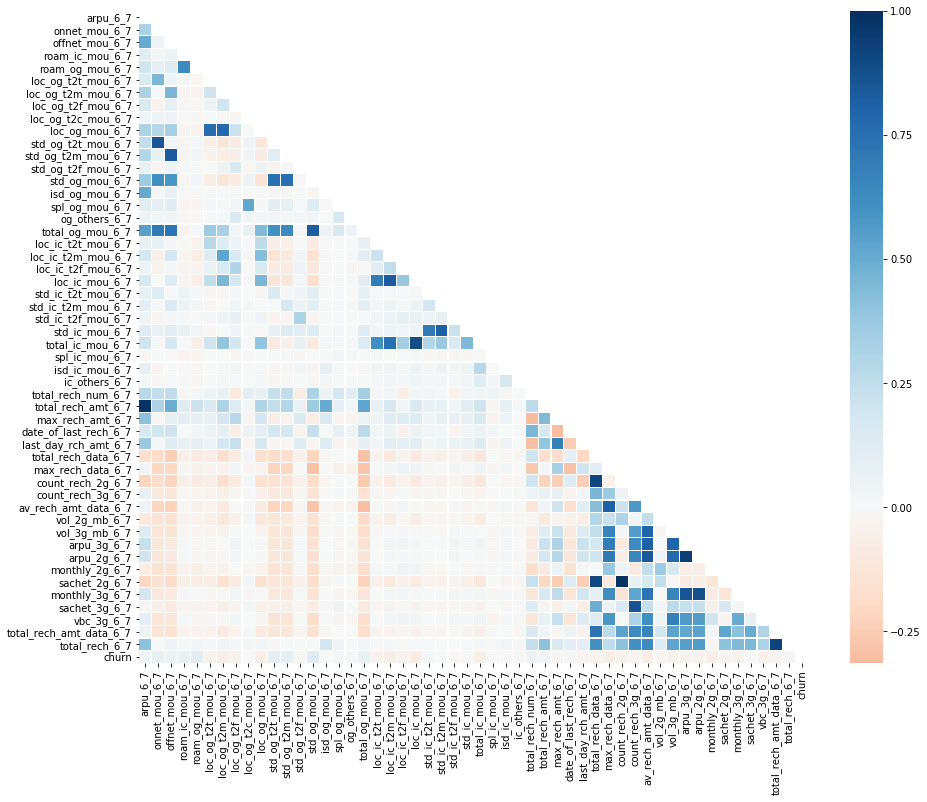

In [52]:
#Correlation of Good Phase Data
col = [c for c in hvCust.columns if c.endswith('_6_7') ] + ['churn']
corrData_6_7 = hvCust[col].corr()
plt.figure(figsize=(15,12))
mask = np.zeros_like(corrData_6_7, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrData_6_7, cmap='RdBu', mask=mask, center=0, linewidths= 0.1)
plt.show()

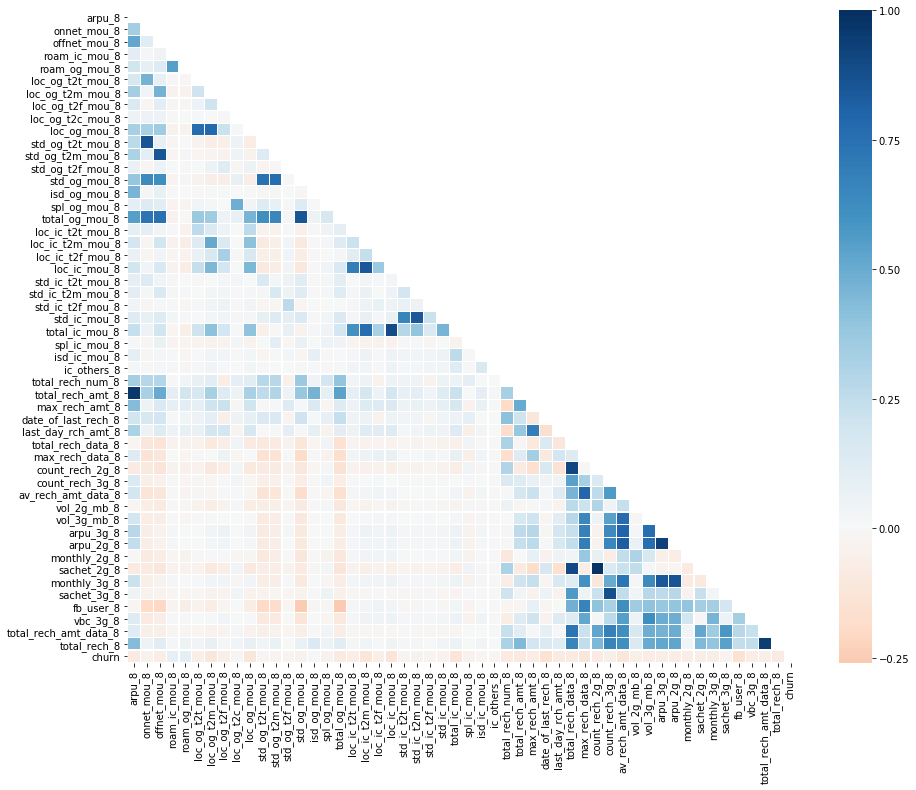

In [53]:
#Correlation of Action Phase Data
col = [c for c in hvCust.columns if c.endswith('_8') ] + ['churn']
corrData_8 = hvCust[col].corr()
plt.figure(figsize=(15,12))
mask = np.zeros_like(corrData_8, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrData_8, cmap='RdBu', mask=mask, center=0, linewidths= 0.1)
plt.show()

Both heatmap shows similar trend, will drop few highly correlated column.

In [54]:
for c in corrData_6_7.columns:
    corrCol = corrData_6_7[(corrData_6_7[c] >= 0.8) & (corrData_6_7[c] < 1)].index
    if (corrCol.size > 0):
        print("'{0}' correlated with '{1}' : {2}".format(c, corrCol[0], corrData_6_7.loc[c, corrCol[0]]))
print()        
print('-----------------------------------------------------------------')
print()
for c in corrData_8.columns:
    corrCol = corrData_8[(corrData_8[c] >= 0.8) & (corrData_8[c] < 1)].index
    if (corrCol.size > 0):
        print("'{0}' correlated with '{1}' : {2}".format(c, corrCol[0], corrData_8.loc[c, corrCol[0]]))

'arpu_6_7' correlated with 'total_rech_amt_6_7' : 0.9807394665291236
'onnet_mou_6_7' correlated with 'std_og_t2t_mou_6_7' : 0.8532342495252453
'offnet_mou_6_7' correlated with 'std_og_t2m_mou_6_7' : 0.8378648579136188
'std_og_t2t_mou_6_7' correlated with 'onnet_mou_6_7' : 0.8532342495252453
'std_og_t2m_mou_6_7' correlated with 'offnet_mou_6_7' : 0.8378648579136188
'std_og_mou_6_7' correlated with 'total_og_mou_6_7' : 0.8306598698014078
'total_og_mou_6_7' correlated with 'std_og_mou_6_7' : 0.8306598698014078
'loc_ic_t2m_mou_6_7' correlated with 'loc_ic_mou_6_7' : 0.8390201505961243
'loc_ic_mou_6_7' correlated with 'loc_ic_t2m_mou_6_7' : 0.8390201505961243
'std_ic_t2m_mou_6_7' correlated with 'std_ic_mou_6_7' : 0.8148677594191372
'std_ic_mou_6_7' correlated with 'std_ic_t2m_mou_6_7' : 0.8148677594191372
'total_ic_mou_6_7' correlated with 'loc_ic_mou_6_7' : 0.8918093650110335
'total_rech_amt_6_7' correlated with 'arpu_6_7' : 0.9807394665291236
'total_rech_data_6_7' correlated with 'count_

In [55]:
#Let's drop highly correlated Columns
colToDrop = ['total_rech_amt_6_7','total_rech_amt_8','std_og_t2t_mou_6_7','std_og_t2t_mou_8','std_og_t2m_mou_6_7','std_og_t2m_mou_8','std_og_mou_6_7','std_og_mou_8','loc_ic_mou_6_7','loc_ic_mou_8','std_ic_t2m_mou_6_7','std_ic_t2m_mou_8','total_rech_data_6_7','total_rech_data_8','sachet_3g_6_7','sachet_3g_8','sachet_2g_6_7','sachet_2g_8']
hvCust.drop(labels=colToDrop, inplace=True, axis=1)

In [56]:
hvCust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28163 entries, 7 to 99997
Data columns (total 89 columns):
mobile_number              28163 non-null int64
arpu_8                     28163 non-null float64
onnet_mou_8                28163 non-null float64
offnet_mou_8               28163 non-null float64
roam_ic_mou_8              28163 non-null float64
roam_og_mou_8              28163 non-null float64
loc_og_t2t_mou_8           28163 non-null float64
loc_og_t2m_mou_8           28163 non-null float64
loc_og_t2f_mou_8           28163 non-null float64
loc_og_t2c_mou_8           28163 non-null float64
loc_og_mou_8               28163 non-null float64
std_og_t2f_mou_8           28163 non-null float64
isd_og_mou_8               28163 non-null float64
spl_og_mou_8               28163 non-null float64
total_og_mou_8             28163 non-null float64
loc_ic_t2t_mou_8           28163 non-null float64
loc_ic_t2m_mou_8           28163 non-null float64
loc_ic_t2f_mou_8           28163 non-null f

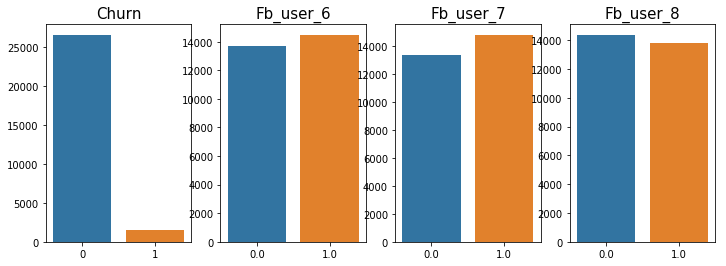

In [57]:
cols = ['fb_user_6','fb_user_7','fb_user_8','churn']
n_cols = 4
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12,4))
for i,c in enumerate(sorted(cols)):
    plt.subplot(n_rows, n_cols, i+1)
    ax = sns.countplot(x=hvCust[c])
    ax.set_xlabel('')
    ax.set_ylabel('')

    plt.title(c.capitalize(), y=1, fontsize=15)
    
plt.show()

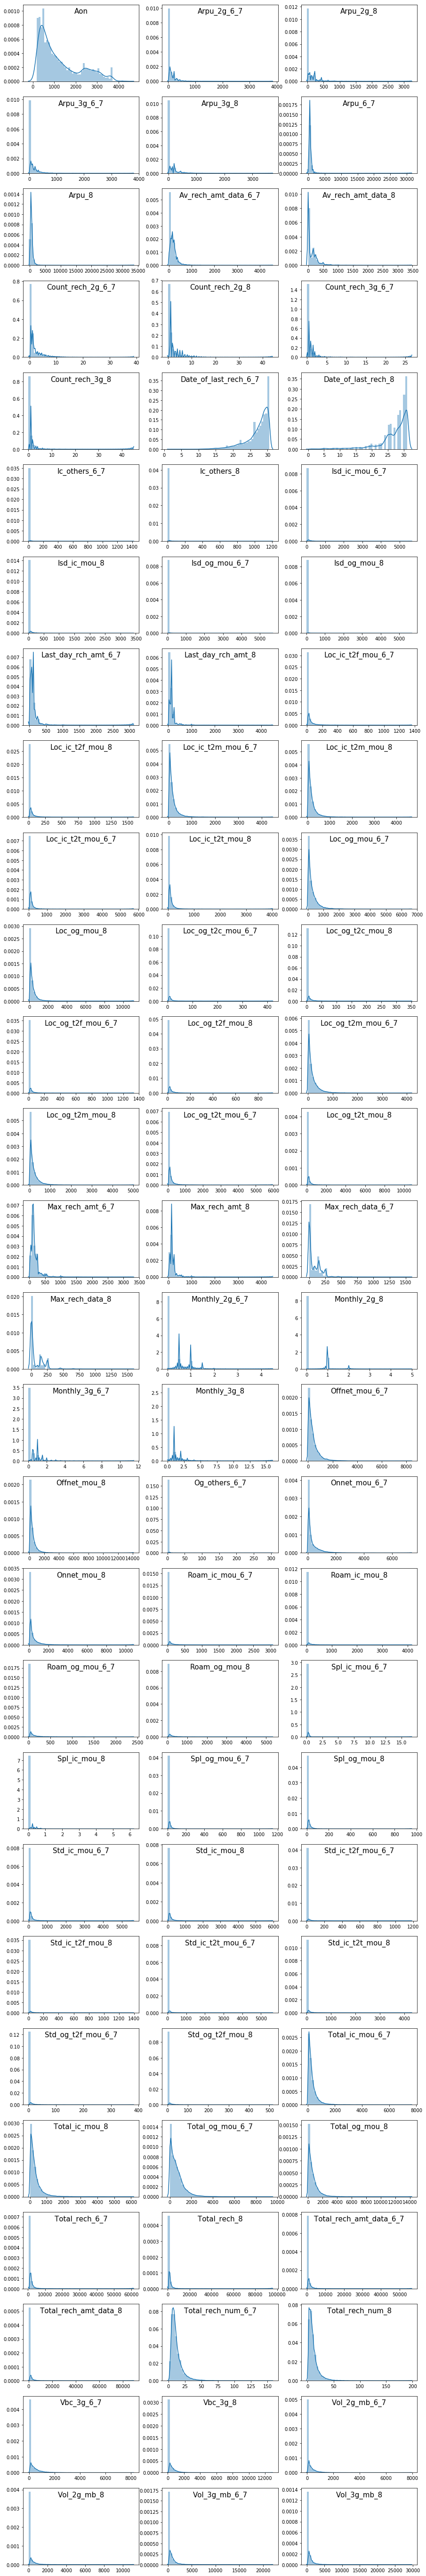

In [58]:
cols = hvCust.columns[~hvCust.columns.isin(['mobile_number','fb_user_6','fb_user_7','fb_user_8','churn'])]
n_cols = 3
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(15,100))
for i,c in enumerate(sorted(cols)):
    plt.subplot(n_rows, n_cols, i+1)
    ax = sns.distplot(hvCust[c])
    ax.set_xlabel('')
    
    plt.title(c.capitalize(), y=0.85, fontsize=15)
    
plt.show()

All feature variables are either skewed to right or left, not a single variable showing normal distribution.<BR>
We are analyzing high value customers which is nothing but outliers, so we can expect such trend in all other variable. <BR>
Will remove outliers using 3-Sigma method. (Observation away from 3 Standard Deviation will be removed.)

**Removing Outlier**

In [59]:
#Calculate Upper & Lower Limit of 3 Standard Deviation 
hvCust_3SD_upper = hvCust.mean() + (hvCust.std()*3)
hvCust_3SD_lower = hvCust.mean() - (hvCust.std()*3)
bak_hvCust = hvCust.copy()
hvCust.shape

(28163, 89)

In [60]:
cols = ['mobile_number','fb_user_6','fb_user_7','fb_user_8','churn','aon','date_of_last_rech_6_7','date_of_last_rech_8']
for c in hvCust.columns[~hvCust.columns.isin(cols)]:
    hvCust = hvCust[(hvCust[c] <= hvCust_3SD_upper[c]) & (hvCust[c] >= hvCust_3SD_lower[c])]    

In [61]:
hvCust.shape

(15916, 89)

## Model Building

In [62]:
#data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

#Util
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold

#Model Algo
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Model Evluation
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Display Tree Structure
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [63]:
print("Class Ratio")
print(round(hvCust['churn'].value_counts() / hvCust.index.size, 2))

Class Ratio
0    0.94
1    0.06
Name: churn, dtype: float64


In [64]:
#Split Train & Test Data
Y = hvCust['churn']
X = hvCust.drop(labels=['churn','mobile_number'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.7, random_state = 100, stratify = Y)
print("Train Set :", X_train.shape, Y_train.shape)
print("Test Set :", X_test.shape, Y_test.shape)

Train Set : (11141, 87) (11141,)
Test Set : (4775, 87) (4775,)


In [65]:
#Scale data using Standard Scaler
sc = StandardScaler()
X_train[X_train.columns] = sc.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = sc.transform(X_test[X_test.columns])

**Generic Method to get Model Building, Evaluate & VIF score**

In [66]:
def EvaluateModel(model, data, y_actual):
    prob = model.predict_proba(data)[:, 1]
    pred = model.predict(data)
            
    pred_df = pd.DataFrame(data= {'Churned' : y_actual.values, 'Churn_Prob':prob.reshape(-1), 'Churn_Pred':pred.reshape(-1)})
    pred_df['Id'] = y_actual.index
    
    accuracy = round(accuracy_score(pred_df['Churned'], pred_df['Churn_Pred'] ), 2)
    recall = round(recall_score(pred_df['Churned'], pred_df['Churn_Pred'] ), 2)
    auc = round(roc_auc_score(pred_df['Churned'], pred_df['Churn_Pred'] ), 2)
    confu_matrix = confusion_matrix(pred_df['Churned'], pred_df['Churn_Pred'] )
    
    print("Accuracy : ", accuracy)
    print("Recall : ", recall)
    print("ROC - AUC : ", auc)
    print("Confusion Matrix :")
    print(confu_matrix)
    return pred_df

In [67]:
def GetLRModel(X_train, y_train):
    X_train_lm = sm.add_constant(X_train)
    lr = sm.GLM(y_train, X_train_lm, family=sm.families.Binomial()).fit()
    print(lr.summary())
    return (lr, X_train_lm)

In [68]:
def GetVIFScore(df):
    vifScore = pd.DataFrame()
    vifScore['Features'] = df.columns
    vifScore['VIF'] = [round(variance_inflation_factor(df.values, i),2) for i in range(df.shape[1])]
    return vifScore.sort_values(by='VIF', ascending=False)

In [69]:
pca = PCA(svd_solver='randomized', random_state=100)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
  svd_solver='randomized', tol=0.0, whiten=False)

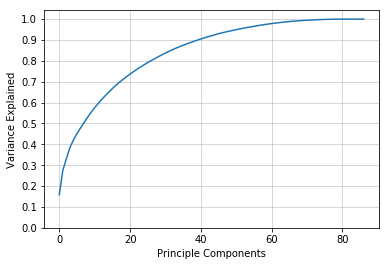

In [70]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(linestyle='-', linewidth = 0.5)
plt.xlabel('Principle Components')
plt.ylabel('Variance Explained')
plt.show()

In [71]:
np.cumsum(pca.explained_variance_ratio_)[np.arange(29,89,5)]

array([0.82904169, 0.86799659, 0.89942517, 0.92542961, 0.94589196,
       0.96267742, 0.97642313, 0.98684009, 0.99365585, 0.9980032 ,
       0.99993155, 1.        ])

**90%** variance explained by **40** PC<BR>
**93%** variance explained by **45** PC<BR>
**95%** variance explained by **50** PC<BR>
**96%** variance explained by **55** PC<BR>
**98%** variance explained by **60** PC<BR>
So, we can choose **50 or 55** PC for model building which explained **95% - 96%** variance.

In [72]:
pca = IncrementalPCA(n_components=50)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

In [73]:
#Create 5 Fold Cross Validation Using Stratified H Fold which will also help in class imbalance problem
folds = StratifiedKFold(n_splits = 5, random_state = 100, shuffle = True)

Build different models using Grid Search CV<BR>
Will use **'Sensitivity'** Or **'Recall'** as our scoring parameter, because we have to identify Churners more accurately than non churner.

**Logistic Regression**

In [74]:
#As Churner ratio is not balanced, we have use Class Weight as one of the important parameters while building model
#We Can Use Class Weight value as "Balanced" Or Churn class Ratio

lr = LogisticRegression(random_state=100)
param = {'C' : [0.0001,0.001,0.1,1], 
         'class_weight' : ['balanced', {0:6,1:94}]}
model_lr = GridSearchCV(lr, param_grid=param, scoring='recall', cv=folds, n_jobs=-1, verbose=1, return_train_score=True, )
model_lr.fit(pca_train, Y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.1, 1], 'class_weight': ['balanced', {0: 6, 1: 94}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [75]:
lrScore = pd.DataFrame(model_lr.cv_results_)
lrScore[['mean_test_score','mean_train_score'] + [c for c in lrScore.columns if c.startswith('param_')]].sort_values(by=['mean_test_score','mean_train_score'], ascending=False)

,mean_test_score,mean_train_score,param_C,param_class_weight
0,0.921230,0.924220,0.0001,balanced
2,0.870725,0.874814,0.001,balanced
1,0.870725,0.873699,0.0001,"{0: 6, 1: 94}"
3,0.827591,0.842123,0.001,"{0: 6, 1: 94}"
4,0.823135,0.834694,0.1,balanced
5,0.823135,0.834694,0.1,"{0: 6, 1: 94}"
7,0.823135,0.834694,1,"{0: 6, 1: 94}"
6,0.821643,0.833579,1,balanced


In [76]:
model_lr.best_params_

{'C': 0.0001, 'class_weight': 'balanced'}

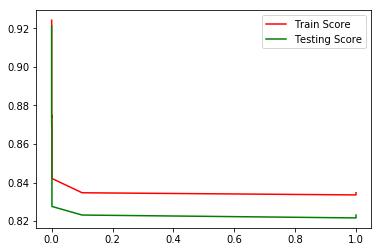

In [77]:
plt.plot(lrScore['param_C'], lrScore['mean_train_score'], 'r')
plt.plot(lrScore['param_C'], lrScore['mean_test_score'], 'g')  
plt.legend(['Train Score','Testing Score'])
plt.show()

In [78]:
#Based on above graph will pick lower value of 'C', which is  0.0001
final_lr = LogisticRegression(class_weight='balanced', C=0.00001)
final_lr.fit(pca_train, Y_train)

LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

**Training Data Score**

Accuracy :  0.52
Recall :  0.93
ROC - AUC :  0.71
Confusion Matrix :
[[5152 5316]
 [  47  626]]


**Testing Data Score**

Accuracy :  0.53
Recall :  0.92
ROC - AUC :  0.71
Confusion Matrix :
[[2243 2244]
 [  22  266]]


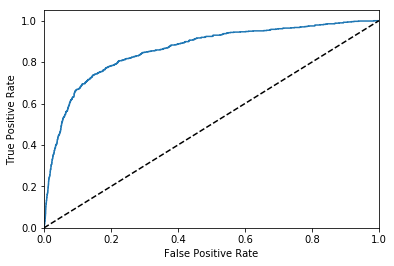

In [79]:
customprint('**Training Data Score**')
lr_train_df = EvaluateModel(final_lr, pca_train, Y_train)

customprint('**Testing Data Score**')
lr_test_df = EvaluateModel(final_lr, pca_test, Y_test)

FP, TP, thresholds = roc_curve( lr_train_df['Churned'], lr_train_df['Churn_Prob'], drop_intermediate = False )
plt.plot(FP, TP)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Decision Tree**

In [80]:
#Using iterative process for model tuning using different hyper parameters
dt = DecisionTreeClassifier(class_weight='balanced', random_state=100)
param = {'max_depth' : range(2,20,5),
        'max_features' : range(5,30,5),
        'min_samples_leaf' : range(100,300,20),
        'min_samples_split' : range(200,600,200)}
model_dt = GridSearchCV(dt,
                        param_grid=param,
                        cv=folds,
                        scoring='recall',
                        verbose=1,
                        n_jobs=-1)
model_dt.fit(pca_train, Y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 1289 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 1993 out of 2000 | elapsed:  1.5min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(2, 20, 5), 'max_features': range(5, 30, 5), 'min_samples_leaf': range(100, 300, 20), 'min_samples_split': range(200, 600, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [81]:
dtScore = pd.DataFrame(model_dt.cv_results_)
dtScore[['mean_test_score','mean_train_score'] + [c for c in dtScore.columns if c.startswith('param_')]].sort_values(by=['mean_test_score','mean_train_score'], ascending=False)

,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
0,0.855866,0.864779,2,5,100,200
1,0.855866,0.864779,2,5,100,400
2,0.855866,0.864779,2,5,120,200
3,0.855866,0.864779,2,5,120,400
4,0.855866,0.864779,2,5,140,200
5,0.855866,0.864779,2,5,140,400
6,0.855866,0.864779,2,5,160,200
7,0.855866,0.864779,2,5,160,400
8,0.855866,0.864779,2,5,180,200
9,0.855866,0.864779,2,5,180,400


In [82]:
model_dt.best_params_

{'max_depth': 2,
 'max_features': 5,
 'min_samples_leaf': 100,
 'min_samples_split': 200}

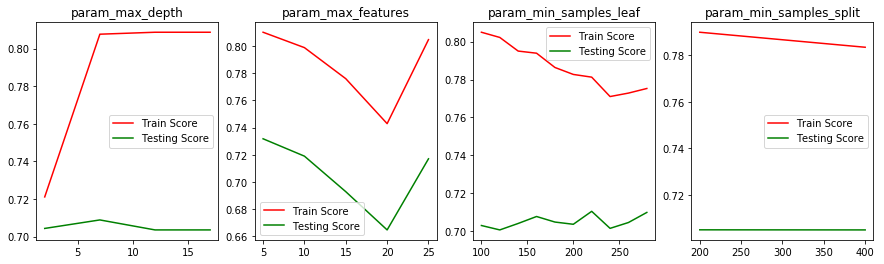

In [83]:
plt.figure(figsize=(15,4))
i = 1
for c in dtScore.columns:
    if c.startswith('param_'):
        tempDf = dtScore.groupby(by=c).mean()
        plt.subplot(1,4,i)
        plt.plot(tempDf.index, tempDf['mean_train_score'], 'r')
        plt.plot(tempDf.index, tempDf['mean_test_score'], 'g')  
        plt.legend(['Train Score','Testing Score'])
        plt.title(c)
        i = i + 1
        
plt.show()

In [84]:
#Based on above graph will pick lower value of 'C', which is  0.0001
final_dt = DecisionTreeClassifier(class_weight='balanced', max_depth=2, max_features=5, min_samples_leaf=100, min_samples_split=200, random_state=100)
final_dt.fit(pca_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

**Training Data Score**

Accuracy :  0.43
Recall :  0.87
ROC - AUC :  0.63
Confusion Matrix :
[[4217 6251]
 [  90  583]]


**Testing Data Score**

Accuracy :  0.43
Recall :  0.82
ROC - AUC :  0.62
Confusion Matrix :
[[1837 2650]
 [  51  237]]


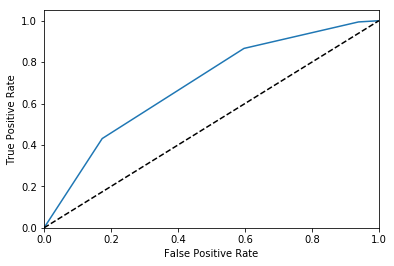

In [85]:
customprint('**Training Data Score**')
dt_train_df = EvaluateModel(final_dt, pca_train, Y_train)

customprint('**Testing Data Score**')
dt_test_df = EvaluateModel(final_dt, pca_test, Y_test)

FP, TP, thresholds = roc_curve( dt_train_df['Churned'], dt_train_df['Churn_Prob'], drop_intermediate = False )
plt.plot(FP, TP)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Random Forest**

In [86]:
#Random Forest Classifier
rfc = RandomForestClassifier(class_weight="balanced", random_state=100)
param = {'max_depth': [5,10,20],
        'max_features': [15,20,25],
        'min_samples_leaf': [300,500,600,700],
        'min_samples_split': [50,100,200]
        }
model_rf = GridSearchCV(rfc,
                         param_grid=param, 
                         scoring='recall', 
                         cv=folds, 
                         verbose=1,
                         n_jobs = -1,
                         return_train_score=True)
model_rf.fit(pca_train, Y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=100,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 10, 20], 'max_features': [15, 20, 25], 'min_samples_leaf': [300, 500, 600, 700], 'min_samples_split': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [87]:
rfScore = pd.DataFrame(model_rf.cv_results_)
rfScore[['mean_test_score','mean_train_score'] + [c for c in rfScore.columns if c.startswith('param_')]].sort_values(by=['mean_test_score','mean_train_score'], ascending=False)

,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
18,0.756299,0.781948,5,20,600,50
19,0.756299,0.781948,5,20,600,100
20,0.756299,0.781948,5,20,600,200
54,0.756299,0.781948,10,20,600,50
55,0.756299,0.781948,10,20,600,100
56,0.756299,0.781948,10,20,600,200
90,0.756299,0.781948,20,20,600,50
91,0.756299,0.781948,20,20,600,100
92,0.756299,0.781948,20,20,600,200
15,0.751862,0.777860,5,20,500,50


In [88]:
model_rf.best_params_

{'max_depth': 5,
 'max_features': 20,
 'min_samples_leaf': 600,
 'min_samples_split': 50}

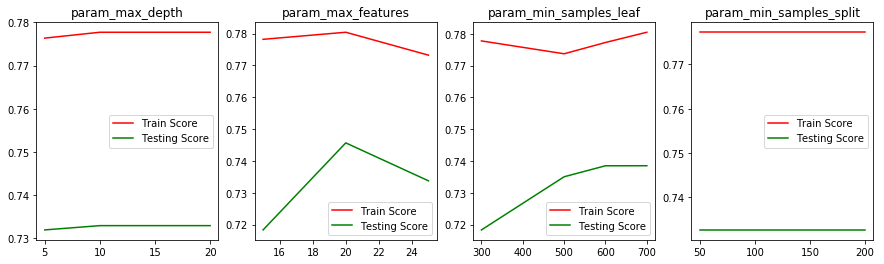

In [89]:
plt.figure(figsize=(15,4))
i = 1
for c in rfScore.columns:
    if c.startswith('param_'):
        tempDf = rfScore.groupby(by=c).mean()
        plt.subplot(1,4,i)
        plt.plot(tempDf.index, tempDf['mean_train_score'], 'r')
        plt.plot(tempDf.index, tempDf['mean_test_score'], 'g')  
        plt.legend(['Train Score','Testing Score'])
        plt.title(c)
        i = i + 1
        
plt.show()

In [90]:
#Based on above graph will pick lower value of 'C', which is  0.0001
#final_dt = DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_features=15, min_samples_leaf=140, min_samples_split=600)
final_dt = RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=20, min_samples_leaf=600, min_samples_split=50, random_state=100)
final_dt.fit(pca_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=20,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=600,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=100,
            verbose=0, warm_start=False)

**Training Data Score**

Accuracy :  0.79
Recall :  0.78
ROC - AUC :  0.79
Confusion Matrix :
[[8252 2216]
 [ 146  527]]


**Testing Data Score**

Accuracy :  0.79
Recall :  0.75
ROC - AUC :  0.77
Confusion Matrix :
[[3577  910]
 [  73  215]]


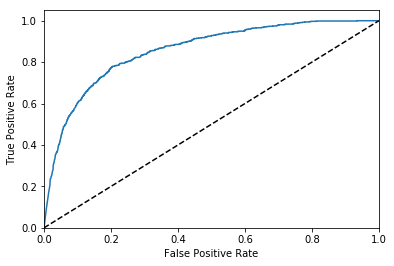

In [91]:
customprint('**Training Data Score**')
dt_train_df = EvaluateModel(final_dt, pca_train, Y_train)

customprint('**Testing Data Score**')
dt_test_df = EvaluateModel(final_dt, pca_test, Y_test)

FP, TP, thresholds = roc_curve( dt_train_df['Churned'], dt_train_df['Churn_Prob'], drop_intermediate = False )
plt.plot(FP, TP)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We are getting high recall value **(93%)** for **Logistic regression Model **<BR>
So we can use **Logistic Regression Model** for Prediction.<BR>

**Find Most Important Predictors or Factors behind Customer Churn, So we can take corrective action against it.**

**Feature Selection**<br>
Will use RFE (Recursive Feature Elimination) technique to select most important features from different available features.

In [92]:
#Instead of building model on all feature will fetch important feature using RFE
rfe = RFE(LogisticRegression(class_weight="balanced"), n_features_to_select=30)
rfe.fit(X_train, Y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=30, step=1, verbose=0)

In [93]:
rfeDF = pd.DataFrame(data=np.array([X_train.columns, rfe.support_, rfe.ranking_]).T, columns=['Feature', 'Support', 'Rank'])
rfeDF[rfeDF['Support']]

,Feature,Support,Rank
0,arpu_8,True,1
3,roam_ic_mou_8,True,1
4,roam_og_mou_8,True,1
8,loc_og_t2c_mou_8,True,1
9,loc_og_mou_8,True,1
13,total_og_mou_8,True,1
18,std_ic_t2f_mou_8,True,1
20,total_ic_mou_8,True,1
21,spl_ic_mou_8,True,1
22,isd_ic_mou_8,True,1


In [94]:
cols  = list(rfeDF[rfeDF['Rank'] == 1]['Feature'])

On each iteration will check P-value and VIF score and based on that will drop in-signification or highly correlated variables.

In [95]:
#Check for multicollinearity using VIF score
GetVIFScore(X_train[cols])

,Features,VIF
19,total_rech_8,41.87
18,total_rech_amt_data_8,28.47
0,arpu_8,15.07
28,arpu_2g_6_7,9.23
27,arpu_3g_6_7,8.30
14,arpu_2g_8,6.57
5,total_og_mou_8,6.36
29,monthly_3g_6_7,6.16
13,av_rech_amt_data_8,5.87
22,total_og_mou_6_7,5.67


In [96]:
lr_1, train_lm_1 = GetLRModel(X_train[cols], Y_train)
GetVIFScore(X_train[cols])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                11141
Model:                            GLM   Df Residuals:                    11110
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1745.1
Date:                Sun, 18 Aug 2019   Deviance:                       3490.1
Time:                        23:43:09   Pearson chi2:                 2.83e+05
No. Iterations:                     8   Covariance Type:             nonrobust
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -4.2172      0.101    -41.835      0.000      -4.415      -4.020
arpu_8             

,Features,VIF
19,total_rech_8,41.87
18,total_rech_amt_data_8,28.47
0,arpu_8,15.07
28,arpu_2g_6_7,9.23
27,arpu_3g_6_7,8.30
14,arpu_2g_8,6.57
5,total_og_mou_8,6.36
29,monthly_3g_6_7,6.16
13,av_rech_amt_data_8,5.87
22,total_og_mou_6_7,5.67


In [97]:
cols.remove('total_rech_8')
lr_2, train_lm_2 = GetLRModel(X_train[cols], Y_train)
GetVIFScore(X_train[cols])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                11141
Model:                            GLM   Df Residuals:                    11111
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1745.1
Date:                Sun, 18 Aug 2019   Deviance:                       3490.2
Time:                        23:43:10   Pearson chi2:                 2.89e+05
No. Iterations:                     8   Covariance Type:             nonrobust
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -4.2172      0.101    -41.837      0.000      -4.415      -4.020
arpu_8             

,Features,VIF
27,arpu_2g_6_7,9.23
26,arpu_3g_6_7,8.29
14,arpu_2g_8,6.57
0,arpu_8,6.40
5,total_og_mou_8,6.22
28,monthly_3g_6_7,6.16
13,av_rech_amt_data_8,5.81
15,monthly_3g_8,5.66
21,total_og_mou_6_7,5.62
19,arpu_6_7,4.36


In [98]:
cols.remove('arpu_3g_6_7')
lr_3, train_lm_3 = GetLRModel(X_train[cols], Y_train)
GetVIFScore(X_train[cols])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                11141
Model:                            GLM   Df Residuals:                    11112
Model Family:                Binomial   Df Model:                           28
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1745.7
Date:                Sun, 18 Aug 2019   Deviance:                       3491.4
Time:                        23:43:12   Pearson chi2:                 2.85e+05
No. Iterations:                     8   Covariance Type:             nonrobust
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -4.2162      0.101    -41.845      0.000      -4.414      -4.019
arpu_8             

,Features,VIF
14,arpu_2g_8,6.57
0,arpu_8,6.39
5,total_og_mou_8,6.20
26,arpu_2g_6_7,6.19
13,av_rech_amt_data_8,5.77
15,monthly_3g_8,5.66
21,total_og_mou_6_7,5.56
27,monthly_3g_6_7,5.52
7,total_ic_mou_8,4.32
19,arpu_6_7,4.26


In [99]:
cols.remove('arpu_8')
lr_4, train_lm_4 = GetLRModel(X_train[cols], Y_train)
GetVIFScore(X_train[cols])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                11141
Model:                            GLM   Df Residuals:                    11113
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1745.8
Date:                Sun, 18 Aug 2019   Deviance:                       3491.5
Time:                        23:43:13   Pearson chi2:                 2.72e+05
No. Iterations:                     8   Covariance Type:             nonrobust
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -4.2141      0.100    -41.972      0.000      -4.411      -4.017
roam_ic_mou_8      

,Features,VIF
13,arpu_2g_8,6.49
25,arpu_2g_6_7,6.14
14,monthly_3g_8,5.66
12,av_rech_amt_data_8,5.52
26,monthly_3g_6_7,5.52
20,total_og_mou_6_7,4.54
6,total_ic_mou_8,4.29
22,total_ic_mou_6_7,4.04
3,loc_og_mou_8,3.75
4,total_og_mou_8,3.45


In [100]:
cols.remove('total_rech_amt_data_8')
lr_5, train_lm_5= GetLRModel(X_train[cols], Y_train)
GetVIFScore(X_train[cols])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                11141
Model:                            GLM   Df Residuals:                    11114
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1745.9
Date:                Sun, 18 Aug 2019   Deviance:                       3491.8
Time:                        23:43:14   Pearson chi2:                 2.84e+05
No. Iterations:                     8   Covariance Type:             nonrobust
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.2108      0.100    -42.060      0.000      -4.407      -4.015
roam_ic_mou_8           0

,Features,VIF
13,arpu_2g_8,6.49
24,arpu_2g_6_7,6.14
14,monthly_3g_8,5.54
25,monthly_3g_6_7,5.52
19,total_og_mou_6_7,4.52
6,total_ic_mou_8,4.29
21,total_ic_mou_6_7,4.04
3,loc_og_mou_8,3.75
4,total_og_mou_8,3.45
17,arpu_6_7,3.11


In [101]:
cols.remove('loc_ic_t2f_mou_6_7')
lr_6, train_lm_6 = GetLRModel(X_train[cols], Y_train)
GetVIFScore(X_train[cols])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                11141
Model:                            GLM   Df Residuals:                    11115
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1746.4
Date:                Sun, 18 Aug 2019   Deviance:                       3492.7
Time:                        23:43:15   Pearson chi2:                 2.88e+05
No. Iterations:                     8   Covariance Type:             nonrobust
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.2106      0.100    -42.058      0.000      -4.407      -4.014
roam_ic_mou_8           0

,Features,VIF
13,arpu_2g_8,6.49
23,arpu_2g_6_7,6.14
14,monthly_3g_8,5.54
24,monthly_3g_6_7,5.52
19,total_og_mou_6_7,4.52
6,total_ic_mou_8,4.29
20,total_ic_mou_6_7,3.81
3,loc_og_mou_8,3.75
4,total_og_mou_8,3.45
17,arpu_6_7,3.11


In [102]:
cols.remove('loc_og_t2m_mou_6_7')
lr_7, train_lm_7 = GetLRModel(X_train[cols], Y_train)
GetVIFScore(X_train[cols])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                11141
Model:                            GLM   Df Residuals:                    11116
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1747.1
Date:                Sun, 18 Aug 2019   Deviance:                       3494.2
Time:                        23:43:16   Pearson chi2:                 2.91e+05
No. Iterations:                     8   Covariance Type:             nonrobust
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.2190      0.100    -42.087      0.000      -4.416      -4.023
roam_ic_mou_8           0

,Features,VIF
13,arpu_2g_8,6.49
22,arpu_2g_6_7,6.14
14,monthly_3g_8,5.53
23,monthly_3g_6_7,5.52
18,total_og_mou_6_7,4.47
6,total_ic_mou_8,4.18
19,total_ic_mou_6_7,3.52
4,total_og_mou_8,3.25
17,arpu_6_7,3.05
12,av_rech_amt_data_8,2.63


In [103]:
cols.remove('std_ic_t2f_mou_8')
lr_8, train_lm_8 = GetLRModel(X_train[cols], Y_train)
GetVIFScore(X_train[cols])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                11141
Model:                            GLM   Df Residuals:                    11117
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1748.6
Date:                Sun, 18 Aug 2019   Deviance:                       3497.2
Time:                        23:43:16   Pearson chi2:                 3.18e+05
No. Iterations:                     8   Covariance Type:             nonrobust
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.2093      0.099    -42.342      0.000      -4.404      -4.014
roam_ic_mou_8           0

,Features,VIF
12,arpu_2g_8,6.49
21,arpu_2g_6_7,6.14
13,monthly_3g_8,5.53
22,monthly_3g_6_7,5.52
17,total_og_mou_6_7,4.47
5,total_ic_mou_8,4.12
18,total_ic_mou_6_7,3.52
4,total_og_mou_8,3.25
16,arpu_6_7,3.05
11,av_rech_amt_data_8,2.63


In [104]:
#Will use above identified Significant variable to Build Logistic Regression Model
lr = LogisticRegression(class_weight="balanced", random_state=100, C=0.001)
lr.fit(X_train[cols], Y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=100,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [105]:
customprint("**Training Score**")
tempDf = EvaluateModel(lr,X_train[cols], Y_train)
customprint("**Testin Score**")
tempDf = EvaluateModel(lr,X_test[cols], Y_test)

**Training Score**

Accuracy :  0.75
Recall :  0.89
ROC - AUC :  0.82
Confusion Matrix :
[[7800 2668]
 [  76  597]]


**Testin Score**

Accuracy :  0.76
Recall :  0.88
ROC - AUC :  0.81
Confusion Matrix :
[[3352 1135]
 [  34  254]]


We are getting very to Recall / Sencitivity score **90%** with this model.

In [106]:
df = pd.DataFrame(data={'Feature' : cols, 'Coef' : lr.coef_.reshape(-1)})
df['Abs_Coef'] = abs(df['Coef'])

In [107]:
df.sort_values(by='Abs_Coef', ascending=False)

,Feature,Coef,Abs_Coef
10,last_day_rch_amt_8,-0.328509,0.328509
5,total_ic_mou_8,-0.325864,0.325864
9,date_of_last_rech_8,-0.299596,0.299596
11,av_rech_amt_data_8,-0.261018,0.261018
3,loc_og_mou_8,-0.260097,0.260097
8,total_rech_num_8,-0.239039,0.239039
17,total_og_mou_6_7,0.227411,0.227411
4,total_og_mou_8,-0.217064,0.217064
15,aon,-0.174226,0.174226
16,arpu_6_7,0.160281,0.160281
